In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib as mpl
import cv2
import time
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.initializers import glorot_normal
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
from matplotlib import pyplot
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras


2022-12-21 10:15:25.736375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 10:15:25.739901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 10:15:25.739996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def dot_product(x):

    return keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):

    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):

    return keras.backend.l2_normalize(x, axis=axis)

In [3]:
train_dir = '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_Products_training/train'
validation_dir = '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_Products_training/validation'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5464 files belonging to 25 classes.


2022-12-21 10:15:28.652546: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:15:28.652971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 10:15:28.653107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 10:15:28.653200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

Found 1717 files belonging to 25 classes.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
conv_base = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=[150,150,3],
    classifier_activation='softmax',
    )

In [8]:
conv_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = conv_base(image_batch)
print(feature_batch.shape)

2022-12-21 10:15:39.805418: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


(32, 5, 5, 1536)


In [10]:
# def build_model():
#     inputs = keras.layers.Input(shape=[150,150,3])

#     conv_base.trainable = False
    
#     x1 = data_augmentation(inputs)
#     x1 = conv_base(x1, training=False)
#     x1 = tf.keras.layers.Dropout(0.3)(x1)
    
#     x1 = (layers.UpSampling2D())(x1)
#     x1 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x1)
#     x1 = (layers.MaxPooling2D((2, 2)))(x1)
#     x1 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x1)
# #     x1 = (layers.MaxPooling2D((2, 2)))(x1)
# #     x1 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x1)
    
#     model1 = tf.keras.Model(inputs, x1)

#     print(model1.summary())
    
#     x2 = data_augmentation(inputs)
#     x2 = conv_base(x2, training=False)
#     x2 = tf.keras.layers.Dropout(0.3)(x2)
    
#     x2 = (layers.UpSampling2D())(x2)
#     x2 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x2)
#     x2 = (layers.MaxPooling2D((2, 2)))(x2)
#     x2 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x2)
# #     x2 = (layers.MaxPooling2D((2, 2)))(x2)
# #     x2 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x2)
    
#     model2 = tf.keras.Model(inputs, x2)

#     print(model2.summary())
    
#     x = model1.output
#     z = model2.output_shape
#     y = model2.output
    

# #   rehape to (batch_size, total_pixels, filter_size)
#     x = keras.layers.Reshape([z[1] * z[2] , z[-1]])(x)
        
#     y = keras.layers.Reshape([z[1] * z[2] , z[-1]])(y)
    
# #   outer products of x, y
#     x = keras.layers.Lambda(dot_product)([x, y])
    
# #   rehape to (batch_size, filter_size_vgg_last_layer*filter_vgg_last_layer)
#     x = keras.layers.Reshape([z[-1]*z[-1]])(x)
        
# #   signed_sqrt
#     x = keras.layers.Lambda(signed_sqrt)(x)
        
# #   L2_norm
#     x = keras.layers.Lambda(L2_norm)(x)

# #   FC-Layer

#     initializer = tf.keras.initializers.GlorotNormal()
            
#     x = keras.layers.Dense(units=439, 
#                            kernel_regularizer=keras.regularizers.l2(0.0),
#                            kernel_initializer=initializer)(x)

#     tensor_prediction = keras.layers.Activation("softmax")(x)

#     model_bilinear = keras.models.Model(inputs=[inputs],
#                                         outputs=[tensor_prediction])
    


#     sgd = keras.optimizers.SGD(lr=1.0, 
#                                decay=0.0,
#                                momentum=0.9)

#     model_bilinear.compile(loss="categorical_crossentropy", 
#                            optimizer=sgd,
#                            metrics=["categorical_accuracy"])

#     model_bilinear.summary()
    
#     return model_bilinear

In [11]:
def build_model():
    inputs = keras.layers.Input(shape=[150,150,3])

    conv_base.trainable = False
    
    last_layer = conv_base.get_layer('block3a_expand_conv')
    last_output = last_layer.output
    
    x1 = tf.keras.layers.Dropout(0.3)(last_output)
    x1 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x1)
    x1 = (layers.MaxPooling2D((2, 2)))(x1)
    x1 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x1)
    x1 = (layers.MaxPooling2D((2, 2)))(x1)
    x1 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x1)
    
    model1 = tf.keras.Model(conv_base.input, x1)

    print(model1.summary())
    
    x2 = tf.keras.layers.Dropout(0.3)(last_output)
    x2 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x2)
    x2 = (layers.MaxPooling2D((2, 2)))(x2)
    x2 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x2)
    x2 = (layers.MaxPooling2D((2, 2)))(x2)
    x2 = (layers.Conv2D(64, (3, 3), activation='relu',padding='same'))(x2)
    
    model2 = tf.keras.Model(conv_base.input, x2)

    print(model2.summary())
    
    x = model1.output
    z = model2.output_shape
    y = model2.output
    

#   rehape to (batch_size, total_pixels, filter_size)
    x = keras.layers.Reshape([z[1] * z[2] , z[-1]])(x)
        
    y = keras.layers.Reshape([z[1] * z[2] , z[-1]])(y)
    
#   outer products of x, y
    x = keras.layers.Lambda(dot_product)([x, y])
    
#   rehape to (batch_size, filter_size_vgg_last_layer*filter_vgg_last_layer)
    x = keras.layers.Reshape([z[-1]*z[-1]])(x)
        
#   signed_sqrt
    x = keras.layers.Lambda(signed_sqrt)(x)
        
#   L2_norm
    x = keras.layers.Lambda(L2_norm)(x)

#   FC-Layer

    initializer = tf.keras.initializers.GlorotNormal()
            
    x = keras.layers.Dense(units=25, 
                           kernel_regularizer=keras.regularizers.l2(0.0),
                           kernel_initializer=initializer)(x)

    tensor_prediction = keras.layers.Activation("softmax")(x)

    model_bilinear = keras.models.Model(inputs=[conv_base.input],
                                        outputs=[tensor_prediction])
    


    sgd = keras.optimizers.SGD(lr=1.0, 
                               decay=0.0,
                               momentum=0.9)

    model_bilinear.compile(loss="categorical_crossentropy", 
                           optimizer=sgd,
                           metrics=["categorical_accuracy"])

    model_bilinear.summary()
    
    return model_bilinear

In [12]:
model = build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

/home/orelit/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./doody_weights_4/weights.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=False)

def train_model(epochs):

    hist = model.fit_generator(
                train_generator, 
                epochs=epochs, 
                validation_data=val_generator,
                workers=3,
                verbose=1,
                callbacks=[model_checkpoint_callback]
            )
        
#     model.save_weights("./bilinear_weights_2/val_acc_" + str(hist.history['val_categorical_accuracy'][-1]) +"_"+ str(epochs)+ ".h5")
    
    return hist

In [17]:
train_datagen = image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
        '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_Products_training/train',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
val_generator = test_datagen.flow_from_directory(
        '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_Products_training/validation',
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=32,
        subset='training',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_products_test',
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1)


Found 5464 images belonging to 25 classes.
Found 1717 images belonging to 25 classes.
Found 59 images belonging to 22 classes.


In [15]:
# hist =train_model(epochs=1)

In [19]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=9e-4, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [17]:
hist =train_model(epochs=100)

/tmp/ipykernel_27307/720949271.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100
171/171 [==============================] - 25s 131ms/step - loss: 3.2185 - categorical_accuracy: 0.0458 - val_loss: 3.2172 - val_categorical_accuracy: 0.0542
Epoch 2/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2164 - categorical_accuracy: 0.0469 - val_loss: 3.2135 - val_categorical_accuracy: 0.0542
Epoch 3/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2145 - categorical_accuracy: 0.0447 - val_loss: 3.2090 - val_categorical_accuracy: 0.0542
Epoch 4/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2127 - categorical_accuracy: 0.0481 - val_loss: 3.2045 - val_categorical_accuracy: 0.0542
Epoch 5/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2108 - categorical_accuracy: 0.0480 - val_loss: 3.1997 - val_categorical_accuracy: 0.0542
Epoch 6/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2083 - categorical_accuracy: 0.0536 - val_loss: 3.1958 - val_categoric

Epoch 49/100
171/171 [==============================] - 22s 125ms/step - loss: 2.0704 - categorical_accuracy: 0.8217 - val_loss: 2.7937 - val_categorical_accuracy: 0.2289
Epoch 50/100
171/171 [==============================] - 22s 126ms/step - loss: 2.0403 - categorical_accuracy: 0.8276 - val_loss: 2.2690 - val_categorical_accuracy: 0.6506
Epoch 51/100
171/171 [==============================] - 22s 126ms/step - loss: 2.0133 - categorical_accuracy: 0.8338 - val_loss: 2.0937 - val_categorical_accuracy: 0.6948
Epoch 52/100
171/171 [==============================] - 22s 127ms/step - loss: 1.9874 - categorical_accuracy: 0.8395 - val_loss: 2.4675 - val_categorical_accuracy: 0.4118
Epoch 53/100
171/171 [==============================] - 22s 126ms/step - loss: 1.9610 - categorical_accuracy: 0.8435 - val_loss: 3.1474 - val_categorical_accuracy: 0.0711
Epoch 54/100
171/171 [==============================] - 22s 126ms/step - loss: 1.9344 - categorical_accuracy: 0.8631 - val_loss: 2.8568 - val_cat

Epoch 97/100
171/171 [==============================] - 22s 127ms/step - loss: 1.0118 - categorical_accuracy: 0.9843 - val_loss: 3.4927 - val_categorical_accuracy: 0.1147
Epoch 98/100
171/171 [==============================] - 22s 126ms/step - loss: 0.9949 - categorical_accuracy: 0.9874 - val_loss: 2.3409 - val_categorical_accuracy: 0.4001
Epoch 99/100
171/171 [==============================] - 22s 127ms/step - loss: 0.9812 - categorical_accuracy: 0.9890 - val_loss: 3.4053 - val_categorical_accuracy: 0.0623
Epoch 100/100
171/171 [==============================] - 22s 127ms/step - loss: 0.9638 - categorical_accuracy: 0.9896 - val_loss: 3.3065 - val_categorical_accuracy: 0.0291


In [18]:
print(hist.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


# Visualizations for model with hyper-parameters  
learning_rate = 9e-4

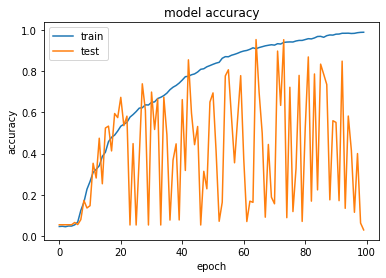

In [19]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

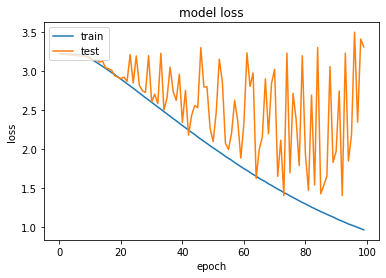

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=1e-4, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [22]:
hist =train_model(epochs=100)

/tmp/ipykernel_36544/2677071310.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100
171/171 [==============================] - 22s 129ms/step - loss: 3.2191 - categorical_accuracy: 0.0498 - val_loss: 3.2186 - val_categorical_accuracy: 0.0542
Epoch 2/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2188 - categorical_accuracy: 0.0523 - val_loss: 3.2178 - val_categorical_accuracy: 0.0419
Epoch 3/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2186 - categorical_accuracy: 0.0503 - val_loss: 3.2174 - val_categorical_accuracy: 0.0402
Epoch 4/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2185 - categorical_accuracy: 0.0560 - val_loss: 3.2171 - val_categorical_accuracy: 0.0600
Epoch 5/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2182 - categorical_accuracy: 0.0522 - val_loss: 3.2166 - val_categorical_accuracy: 0.0635
Epoch 6/100
171/171 [==============================] - 22s 128ms/step - loss: 3.2180 - categorical_accuracy: 0.0547 - val_loss: 3.2160 - val_categoric

Epoch 49/100
171/171 [==============================] - 22s 128ms/step - loss: 3.2101 - categorical_accuracy: 0.1230 - val_loss: 3.1990 - val_categorical_accuracy: 0.1491
Epoch 50/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2099 - categorical_accuracy: 0.1389 - val_loss: 3.1986 - val_categorical_accuracy: 0.1567
Epoch 51/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2098 - categorical_accuracy: 0.1391 - val_loss: 3.1982 - val_categorical_accuracy: 0.1590
Epoch 52/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2095 - categorical_accuracy: 0.1396 - val_loss: 3.1979 - val_categorical_accuracy: 0.1759
Epoch 53/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2093 - categorical_accuracy: 0.1428 - val_loss: 3.1974 - val_categorical_accuracy: 0.1817
Epoch 54/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2091 - categorical_accuracy: 0.1418 - val_loss: 3.1970 - val_cat

Epoch 97/100
171/171 [==============================] - 22s 126ms/step - loss: 3.1800 - categorical_accuracy: 0.3106 - val_loss: 3.1609 - val_categorical_accuracy: 0.4339
Epoch 98/100
171/171 [==============================] - 22s 126ms/step - loss: 3.1784 - categorical_accuracy: 0.3113 - val_loss: 3.1589 - val_categorical_accuracy: 0.4450
Epoch 99/100
171/171 [==============================] - 22s 126ms/step - loss: 3.1770 - categorical_accuracy: 0.3142 - val_loss: 3.1579 - val_categorical_accuracy: 0.4345
Epoch 100/100
171/171 [==============================] - 22s 126ms/step - loss: 3.1752 - categorical_accuracy: 0.3183 - val_loss: 3.1554 - val_categorical_accuracy: 0.4380


# Visualizations for model with hyper-parameters  
learning_rate = 1e-4

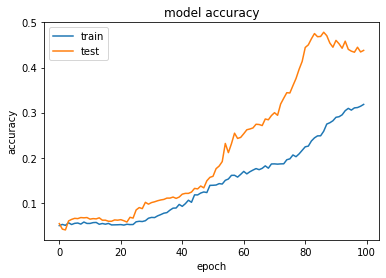

In [23]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

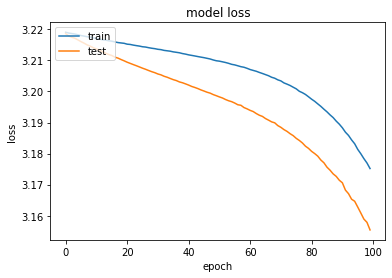

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Continuing training with learning rate of 1e-9 for another 500 epochs

In [25]:
hist =train_model(epochs=500)

/tmp/ipykernel_36544/2677071310.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/500
171/171 [==============================] - 22s 127ms/step - loss: 3.1734 - categorical_accuracy: 0.3173 - val_loss: 3.1534 - val_categorical_accuracy: 0.4380
Epoch 2/500
171/171 [==============================] - 22s 127ms/step - loss: 3.1713 - categorical_accuracy: 0.3152 - val_loss: 3.1511 - val_categorical_accuracy: 0.4345
Epoch 3/500
171/171 [==============================] - 22s 127ms/step - loss: 3.1696 - categorical_accuracy: 0.3130 - val_loss: 3.1511 - val_categorical_accuracy: 0.4054
Epoch 4/500
171/171 [==============================] - 22s 129ms/step - loss: 3.1676 - categorical_accuracy: 0.3150 - val_loss: 3.1473 - val_categorical_accuracy: 0.4153
Epoch 5/500
171/171 [==============================] - 22s 129ms/step - loss: 3.1656 - categorical_accuracy: 0.3201 - val_loss: 3.1448 - val_categorical_accuracy: 0.4106
Epoch 6/500
171/171 [==============================] - 22s 130ms/step - loss: 3.1636 - categorical_accuracy: 0.3199 - val_loss: 3.1433 - val_categoric

Epoch 49/500
171/171 [==============================] - 22s 129ms/step - loss: 3.0415 - categorical_accuracy: 0.3587 - val_loss: 3.0337 - val_categorical_accuracy: 0.3535
Epoch 50/500
171/171 [==============================] - 22s 129ms/step - loss: 3.0373 - categorical_accuracy: 0.3640 - val_loss: 3.0278 - val_categorical_accuracy: 0.3547
Epoch 51/500
171/171 [==============================] - 22s 131ms/step - loss: 3.0350 - categorical_accuracy: 0.3686 - val_loss: 3.1394 - val_categorical_accuracy: 0.1048
Epoch 52/500
171/171 [==============================] - 22s 130ms/step - loss: 3.0317 - categorical_accuracy: 0.3701 - val_loss: 3.0078 - val_categorical_accuracy: 0.4409
Epoch 53/500
171/171 [==============================] - 22s 129ms/step - loss: 3.0288 - categorical_accuracy: 0.3704 - val_loss: 3.1288 - val_categorical_accuracy: 0.1066
Epoch 54/500
171/171 [==============================] - 22s 130ms/step - loss: 3.0256 - categorical_accuracy: 0.3765 - val_loss: 3.0123 - val_cat

Epoch 97/500
171/171 [==============================] - 22s 128ms/step - loss: 2.8932 - categorical_accuracy: 0.4431 - val_loss: 2.9147 - val_categorical_accuracy: 0.4019
Epoch 98/500
171/171 [==============================] - 22s 127ms/step - loss: 2.8913 - categorical_accuracy: 0.4409 - val_loss: 2.8625 - val_categorical_accuracy: 0.4857
Epoch 99/500
171/171 [==============================] - 22s 127ms/step - loss: 2.8868 - categorical_accuracy: 0.4449 - val_loss: 2.8617 - val_categorical_accuracy: 0.5312
Epoch 100/500
171/171 [==============================] - 22s 128ms/step - loss: 2.8843 - categorical_accuracy: 0.4473 - val_loss: 2.8768 - val_categorical_accuracy: 0.5387
Epoch 101/500
171/171 [==============================] - 22s 128ms/step - loss: 2.8802 - categorical_accuracy: 0.4420 - val_loss: 2.8741 - val_categorical_accuracy: 0.5416
Epoch 102/500
171/171 [==============================] - 22s 127ms/step - loss: 2.8776 - categorical_accuracy: 0.4440 - val_loss: 2.8463 - val_

Epoch 145/500
171/171 [==============================] - 21s 125ms/step - loss: 2.7406 - categorical_accuracy: 0.5092 - val_loss: 2.7177 - val_categorical_accuracy: 0.5824
Epoch 146/500
171/171 [==============================] - 21s 124ms/step - loss: 2.7373 - categorical_accuracy: 0.5152 - val_loss: 3.0564 - val_categorical_accuracy: 0.0839
Epoch 147/500
171/171 [==============================] - 22s 126ms/step - loss: 2.7338 - categorical_accuracy: 0.5113 - val_loss: 2.7202 - val_categorical_accuracy: 0.5038
Epoch 148/500
171/171 [==============================] - 21s 125ms/step - loss: 2.7314 - categorical_accuracy: 0.5117 - val_loss: 2.7433 - val_categorical_accuracy: 0.4560
Epoch 149/500
171/171 [==============================] - 21s 125ms/step - loss: 2.7284 - categorical_accuracy: 0.5097 - val_loss: 2.7242 - val_categorical_accuracy: 0.5277
Epoch 150/500
171/171 [==============================] - 22s 125ms/step - loss: 2.7248 - categorical_accuracy: 0.5088 - val_loss: 3.0138 - v

171/171 [==============================] - 22s 126ms/step - loss: 2.5906 - categorical_accuracy: 0.5867 - val_loss: 2.5757 - val_categorical_accuracy: 0.6016
Epoch 193/500
171/171 [==============================] - 22s 125ms/step - loss: 2.5878 - categorical_accuracy: 0.5992 - val_loss: 2.5946 - val_categorical_accuracy: 0.5713
Epoch 194/500
171/171 [==============================] - 21s 125ms/step - loss: 2.5831 - categorical_accuracy: 0.5996 - val_loss: 2.5349 - val_categorical_accuracy: 0.6273
Epoch 195/500
171/171 [==============================] - 21s 124ms/step - loss: 2.5793 - categorical_accuracy: 0.6010 - val_loss: 2.5597 - val_categorical_accuracy: 0.6243
Epoch 196/500
171/171 [==============================] - 21s 124ms/step - loss: 2.5764 - categorical_accuracy: 0.5997 - val_loss: 2.5459 - val_categorical_accuracy: 0.6494
Epoch 197/500
171/171 [==============================] - 21s 125ms/step - loss: 2.5745 - categorical_accuracy: 0.6078 - val_loss: 2.5535 - val_categorical

Epoch 240/500
171/171 [==============================] - 22s 125ms/step - loss: 2.4360 - categorical_accuracy: 0.6750 - val_loss: 2.3863 - val_categorical_accuracy: 0.7467
Epoch 241/500
171/171 [==============================] - 22s 126ms/step - loss: 2.4319 - categorical_accuracy: 0.6794 - val_loss: 2.3827 - val_categorical_accuracy: 0.7356
Epoch 242/500
171/171 [==============================] - 22s 127ms/step - loss: 2.4298 - categorical_accuracy: 0.6830 - val_loss: 2.3852 - val_categorical_accuracy: 0.7257
Epoch 243/500
171/171 [==============================] - 22s 126ms/step - loss: 2.4279 - categorical_accuracy: 0.6711 - val_loss: 2.3859 - val_categorical_accuracy: 0.7560
Epoch 244/500
171/171 [==============================] - 22s 126ms/step - loss: 2.4247 - categorical_accuracy: 0.6757 - val_loss: 2.4379 - val_categorical_accuracy: 0.6669
Epoch 245/500
171/171 [==============================] - 22s 127ms/step - loss: 2.4208 - categorical_accuracy: 0.6795 - val_loss: 2.6341 - v

171/171 [==============================] - 22s 129ms/step - loss: 2.2864 - categorical_accuracy: 0.7284 - val_loss: 2.2229 - val_categorical_accuracy: 0.8084
Epoch 288/500
171/171 [==============================] - 23s 135ms/step - loss: 2.2833 - categorical_accuracy: 0.7258 - val_loss: 2.2343 - val_categorical_accuracy: 0.7833
Epoch 289/500
171/171 [==============================] - 23s 134ms/step - loss: 2.2801 - categorical_accuracy: 0.7257 - val_loss: 2.2681 - val_categorical_accuracy: 0.7100
Epoch 290/500
171/171 [==============================] - 24s 137ms/step - loss: 2.2770 - categorical_accuracy: 0.7275 - val_loss: 2.3036 - val_categorical_accuracy: 0.7012
Epoch 291/500
171/171 [==============================] - 24s 140ms/step - loss: 2.2738 - categorical_accuracy: 0.7299 - val_loss: 2.2956 - val_categorical_accuracy: 0.6896
Epoch 292/500
171/171 [==============================] - 23s 136ms/step - loss: 2.2717 - categorical_accuracy: 0.7321 - val_loss: 2.2522 - val_categorical

Epoch 335/500
171/171 [==============================] - 22s 130ms/step - loss: 2.1373 - categorical_accuracy: 0.7764 - val_loss: 2.2397 - val_categorical_accuracy: 0.6005
Epoch 336/500
171/171 [==============================] - 23s 131ms/step - loss: 2.1333 - categorical_accuracy: 0.7754 - val_loss: 2.0624 - val_categorical_accuracy: 0.8334
Epoch 337/500
171/171 [==============================] - 22s 128ms/step - loss: 2.1322 - categorical_accuracy: 0.7725 - val_loss: 2.0861 - val_categorical_accuracy: 0.7979
Epoch 338/500
171/171 [==============================] - 22s 129ms/step - loss: 2.1283 - categorical_accuracy: 0.7738 - val_loss: 2.0833 - val_categorical_accuracy: 0.7828
Epoch 339/500
171/171 [==============================] - 21s 124ms/step - loss: 2.1253 - categorical_accuracy: 0.7776 - val_loss: 2.0646 - val_categorical_accuracy: 0.8229
Epoch 340/500
171/171 [==============================] - 22s 125ms/step - loss: 2.1222 - categorical_accuracy: 0.7754 - val_loss: 2.1490 - v

171/171 [==============================] - 21s 125ms/step - loss: 1.9943 - categorical_accuracy: 0.8098 - val_loss: 1.9554 - val_categorical_accuracy: 0.8480
Epoch 383/500
171/171 [==============================] - 21s 124ms/step - loss: 1.9911 - categorical_accuracy: 0.8042 - val_loss: 1.9300 - val_categorical_accuracy: 0.8515
Epoch 384/500
171/171 [==============================] - 21s 125ms/step - loss: 1.9865 - categorical_accuracy: 0.8194 - val_loss: 1.9252 - val_categorical_accuracy: 0.8561
Epoch 385/500
171/171 [==============================] - 22s 125ms/step - loss: 1.9818 - categorical_accuracy: 0.8206 - val_loss: 1.9972 - val_categorical_accuracy: 0.7571
Epoch 386/500
171/171 [==============================] - 21s 124ms/step - loss: 1.9811 - categorical_accuracy: 0.8153 - val_loss: 1.9445 - val_categorical_accuracy: 0.8451
Epoch 387/500
171/171 [==============================] - 21s 124ms/step - loss: 1.9784 - categorical_accuracy: 0.8157 - val_loss: 1.9847 - val_categorical

Epoch 430/500
171/171 [==============================] - 22s 125ms/step - loss: 1.8530 - categorical_accuracy: 0.8540 - val_loss: 1.8713 - val_categorical_accuracy: 0.8224
Epoch 431/500
171/171 [==============================] - 21s 125ms/step - loss: 1.8480 - categorical_accuracy: 0.8523 - val_loss: 1.8818 - val_categorical_accuracy: 0.7845
Epoch 432/500
171/171 [==============================] - 21s 125ms/step - loss: 1.8459 - categorical_accuracy: 0.8483 - val_loss: 1.8014 - val_categorical_accuracy: 0.8061
Epoch 433/500
171/171 [==============================] - 21s 125ms/step - loss: 1.8441 - categorical_accuracy: 0.8514 - val_loss: 1.7784 - val_categorical_accuracy: 0.8474
Epoch 434/500
171/171 [==============================] - 22s 125ms/step - loss: 1.8412 - categorical_accuracy: 0.8587 - val_loss: 1.7969 - val_categorical_accuracy: 0.8672
Epoch 435/500
171/171 [==============================] - 22s 126ms/step - loss: 1.8371 - categorical_accuracy: 0.8549 - val_loss: 1.7798 - v

171/171 [==============================] - 22s 125ms/step - loss: 1.7212 - categorical_accuracy: 0.8843 - val_loss: 1.7190 - val_categorical_accuracy: 0.8649
Epoch 478/500
171/171 [==============================] - 21s 125ms/step - loss: 1.7198 - categorical_accuracy: 0.8809 - val_loss: 1.7067 - val_categorical_accuracy: 0.8264
Epoch 479/500
171/171 [==============================] - 21s 125ms/step - loss: 1.7160 - categorical_accuracy: 0.8845 - val_loss: 1.6525 - val_categorical_accuracy: 0.8812
Epoch 480/500
171/171 [==============================] - 22s 125ms/step - loss: 1.7116 - categorical_accuracy: 0.8862 - val_loss: 1.6865 - val_categorical_accuracy: 0.8521
Epoch 481/500
171/171 [==============================] - 21s 125ms/step - loss: 1.7091 - categorical_accuracy: 0.8862 - val_loss: 1.6645 - val_categorical_accuracy: 0.8864
Epoch 482/500
171/171 [==============================] - 21s 125ms/step - loss: 1.7074 - categorical_accuracy: 0.8911 - val_loss: 1.6616 - val_categorical

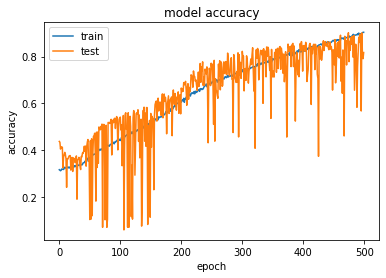

In [26]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

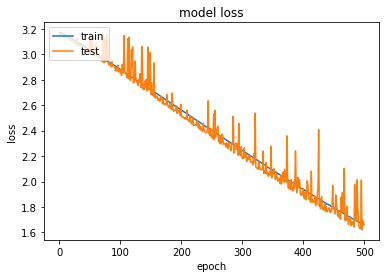

In [27]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Training the model again with smaller learning rate of 1e-5

In [18]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=1e-5, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [19]:
hist =train_model(epochs=100)

/tmp/ipykernel_97520/47992115.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100
171/171 [==============================] - 25s 133ms/step - loss: 3.2181 - categorical_accuracy: 0.0368 - val_loss: 3.2193 - val_categorical_accuracy: 0.0297
Epoch 2/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2181 - categorical_accuracy: 0.0390 - val_loss: 3.2190 - val_categorical_accuracy: 0.0384
Epoch 3/100
171/171 [==============================] - 22s 125ms/step - loss: 3.2181 - categorical_accuracy: 0.0386 - val_loss: 3.2182 - val_categorical_accuracy: 0.0274
Epoch 4/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2180 - categorical_accuracy: 0.0401 - val_loss: 3.2176 - val_categorical_accuracy: 0.0291
Epoch 5/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2180 - categorical_accuracy: 0.0401 - val_loss: 3.2173 - val_categorical_accuracy: 0.0326
Epoch 6/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2179 - categorical_accuracy: 0.0392 - val_loss: 3.2172 - val_categoric

Epoch 49/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2168 - categorical_accuracy: 0.0480 - val_loss: 3.2145 - val_categorical_accuracy: 0.0600
Epoch 50/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2167 - categorical_accuracy: 0.0458 - val_loss: 3.2145 - val_categorical_accuracy: 0.0606
Epoch 51/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2167 - categorical_accuracy: 0.0467 - val_loss: 3.2144 - val_categorical_accuracy: 0.0594
Epoch 52/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2166 - categorical_accuracy: 0.0474 - val_loss: 3.2143 - val_categorical_accuracy: 0.0582
Epoch 53/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2166 - categorical_accuracy: 0.0470 - val_loss: 3.2143 - val_categorical_accuracy: 0.0588
Epoch 54/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2165 - categorical_accuracy: 0.0469 - val_loss: 3.2142 - val_cat

Epoch 97/100
171/171 [==============================] - 23s 134ms/step - loss: 3.2153 - categorical_accuracy: 0.0496 - val_loss: 3.2116 - val_categorical_accuracy: 0.0745
Epoch 98/100
171/171 [==============================] - 23s 132ms/step - loss: 3.2154 - categorical_accuracy: 0.0489 - val_loss: 3.2116 - val_categorical_accuracy: 0.0722
Epoch 99/100
171/171 [==============================] - 22s 131ms/step - loss: 3.2153 - categorical_accuracy: 0.0492 - val_loss: 3.2115 - val_categorical_accuracy: 0.0722
Epoch 100/100
171/171 [==============================] - 22s 131ms/step - loss: 3.2153 - categorical_accuracy: 0.0514 - val_loss: 3.2115 - val_categorical_accuracy: 0.0745


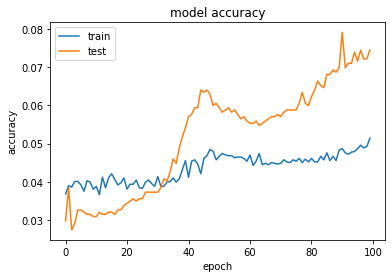

In [20]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

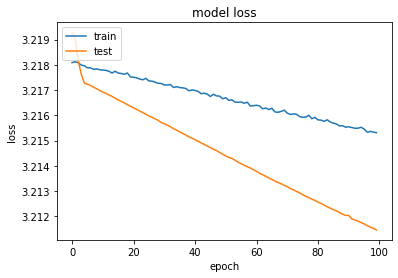

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
hist =train_model(epochs=500)

/tmp/ipykernel_97520/47992115.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/500
171/171 [==============================] - 23s 136ms/step - loss: 3.2153 - categorical_accuracy: 0.0500 - val_loss: 3.2114 - val_categorical_accuracy: 0.0763
Epoch 2/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2153 - categorical_accuracy: 0.0516 - val_loss: 3.2114 - val_categorical_accuracy: 0.0780
Epoch 3/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2152 - categorical_accuracy: 0.0512 - val_loss: 3.2113 - val_categorical_accuracy: 0.0745
Epoch 4/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2152 - categorical_accuracy: 0.0501 - val_loss: 3.2112 - val_categorical_accuracy: 0.0792
Epoch 5/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2152 - categorical_accuracy: 0.0511 - val_loss: 3.2112 - val_categorical_accuracy: 0.0798
Epoch 6/500
171/171 [==============================] - 23s 131ms/step - loss: 3.2152 - categorical_accuracy: 0.0490 - val_loss: 3.2111 - val_categoric

Epoch 49/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2140 - categorical_accuracy: 0.0675 - val_loss: 3.2087 - val_categorical_accuracy: 0.1025
Epoch 50/500
171/171 [==============================] - 23s 131ms/step - loss: 3.2140 - categorical_accuracy: 0.0701 - val_loss: 3.2086 - val_categorical_accuracy: 0.1025
Epoch 51/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2140 - categorical_accuracy: 0.0727 - val_loss: 3.2086 - val_categorical_accuracy: 0.1002
Epoch 52/500
171/171 [==============================] - 23s 133ms/step - loss: 3.2140 - categorical_accuracy: 0.0708 - val_loss: 3.2085 - val_categorical_accuracy: 0.0996
Epoch 53/500
171/171 [==============================] - 24s 139ms/step - loss: 3.2140 - categorical_accuracy: 0.0688 - val_loss: 3.2085 - val_categorical_accuracy: 0.1008
Epoch 54/500
171/171 [==============================] - 24s 137ms/step - loss: 3.2139 - categorical_accuracy: 0.0728 - val_loss: 3.2084 - val_cat

Epoch 97/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2127 - categorical_accuracy: 0.0906 - val_loss: 3.2060 - val_categorical_accuracy: 0.1130
Epoch 98/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2127 - categorical_accuracy: 0.0919 - val_loss: 3.2060 - val_categorical_accuracy: 0.1107
Epoch 99/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2127 - categorical_accuracy: 0.0906 - val_loss: 3.2059 - val_categorical_accuracy: 0.1112
Epoch 100/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2127 - categorical_accuracy: 0.0899 - val_loss: 3.2059 - val_categorical_accuracy: 0.1112
Epoch 101/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2127 - categorical_accuracy: 0.0950 - val_loss: 3.2058 - val_categorical_accuracy: 0.1107
Epoch 102/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2127 - categorical_accuracy: 0.0908 - val_loss: 3.2057 - val_

Epoch 145/500
171/171 [==============================] - 23s 131ms/step - loss: 3.2114 - categorical_accuracy: 0.1023 - val_loss: 3.2033 - val_categorical_accuracy: 0.1200
Epoch 146/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2114 - categorical_accuracy: 0.1045 - val_loss: 3.2033 - val_categorical_accuracy: 0.1211
Epoch 147/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2114 - categorical_accuracy: 0.1058 - val_loss: 3.2033 - val_categorical_accuracy: 0.1200
Epoch 148/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2113 - categorical_accuracy: 0.1051 - val_loss: 3.2032 - val_categorical_accuracy: 0.1200
Epoch 149/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2113 - categorical_accuracy: 0.1076 - val_loss: 3.2031 - val_categorical_accuracy: 0.1206
Epoch 150/500
171/171 [==============================] - 23s 133ms/step - loss: 3.2113 - categorical_accuracy: 0.1036 - val_loss: 3.2031 - v

171/171 [==============================] - 22s 126ms/step - loss: 3.2101 - categorical_accuracy: 0.1182 - val_loss: 3.2007 - val_categorical_accuracy: 0.1293
Epoch 193/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2101 - categorical_accuracy: 0.1175 - val_loss: 3.2007 - val_categorical_accuracy: 0.1316
Epoch 194/500
171/171 [==============================] - 22s 125ms/step - loss: 3.2099 - categorical_accuracy: 0.1179 - val_loss: 3.2006 - val_categorical_accuracy: 0.1316
Epoch 195/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2099 - categorical_accuracy: 0.1166 - val_loss: 3.2005 - val_categorical_accuracy: 0.1340
Epoch 196/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2099 - categorical_accuracy: 0.1180 - val_loss: 3.2005 - val_categorical_accuracy: 0.1369
Epoch 197/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2099 - categorical_accuracy: 0.1206 - val_loss: 3.2005 - val_categorical

Epoch 240/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2084 - categorical_accuracy: 0.1325 - val_loss: 3.1979 - val_categorical_accuracy: 0.1706
Epoch 241/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2083 - categorical_accuracy: 0.1373 - val_loss: 3.1978 - val_categorical_accuracy: 0.1747
Epoch 242/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2084 - categorical_accuracy: 0.1345 - val_loss: 3.1977 - val_categorical_accuracy: 0.1858
Epoch 243/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2083 - categorical_accuracy: 0.1327 - val_loss: 3.1977 - val_categorical_accuracy: 0.1800
Epoch 244/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2083 - categorical_accuracy: 0.1354 - val_loss: 3.1976 - val_categorical_accuracy: 0.1753
Epoch 245/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2081 - categorical_accuracy: 0.1345 - val_loss: 3.1975 - v

171/171 [==============================] - 21s 125ms/step - loss: 3.2066 - categorical_accuracy: 0.1433 - val_loss: 3.1947 - val_categorical_accuracy: 0.2236
Epoch 288/500
171/171 [==============================] - 22s 125ms/step - loss: 3.2064 - categorical_accuracy: 0.1481 - val_loss: 3.1947 - val_categorical_accuracy: 0.2015
Epoch 289/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2066 - categorical_accuracy: 0.1475 - val_loss: 3.1947 - val_categorical_accuracy: 0.2312
Epoch 290/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2065 - categorical_accuracy: 0.1517 - val_loss: 3.1947 - val_categorical_accuracy: 0.2266
Epoch 291/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2064 - categorical_accuracy: 0.1492 - val_loss: 3.1946 - val_categorical_accuracy: 0.2283
Epoch 292/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2064 - categorical_accuracy: 0.1528 - val_loss: 3.1944 - val_categorical

Epoch 335/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2042 - categorical_accuracy: 0.1660 - val_loss: 3.1912 - val_categorical_accuracy: 0.2493
Epoch 336/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2042 - categorical_accuracy: 0.1667 - val_loss: 3.1912 - val_categorical_accuracy: 0.2487
Epoch 337/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2041 - categorical_accuracy: 0.1653 - val_loss: 3.1911 - val_categorical_accuracy: 0.2528
Epoch 338/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2041 - categorical_accuracy: 0.1660 - val_loss: 3.1911 - val_categorical_accuracy: 0.2563
Epoch 339/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2040 - categorical_accuracy: 0.1654 - val_loss: 3.1910 - val_categorical_accuracy: 0.2557
Epoch 340/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2040 - categorical_accuracy: 0.1660 - val_loss: 3.1909 - v

171/171 [==============================] - 21s 124ms/step - loss: 3.2014 - categorical_accuracy: 0.1816 - val_loss: 3.1872 - val_categorical_accuracy: 0.2557
Epoch 383/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2014 - categorical_accuracy: 0.1786 - val_loss: 3.1871 - val_categorical_accuracy: 0.2539
Epoch 384/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2012 - categorical_accuracy: 0.1869 - val_loss: 3.1870 - val_categorical_accuracy: 0.2469
Epoch 385/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2011 - categorical_accuracy: 0.1790 - val_loss: 3.1869 - val_categorical_accuracy: 0.2493
Epoch 386/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2011 - categorical_accuracy: 0.1806 - val_loss: 3.1868 - val_categorical_accuracy: 0.2819
Epoch 387/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2010 - categorical_accuracy: 0.1832 - val_loss: 3.1867 - val_categorical

Epoch 430/500
171/171 [==============================] - 22s 125ms/step - loss: 3.1977 - categorical_accuracy: 0.1945 - val_loss: 3.1822 - val_categorical_accuracy: 0.2941
Epoch 431/500
171/171 [==============================] - 22s 125ms/step - loss: 3.1978 - categorical_accuracy: 0.1947 - val_loss: 3.1819 - val_categorical_accuracy: 0.2935
Epoch 432/500
171/171 [==============================] - 21s 124ms/step - loss: 3.1976 - categorical_accuracy: 0.1960 - val_loss: 3.1818 - val_categorical_accuracy: 0.2941
Epoch 433/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1973 - categorical_accuracy: 0.1980 - val_loss: 3.1817 - val_categorical_accuracy: 0.2755
Epoch 434/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1974 - categorical_accuracy: 0.1982 - val_loss: 3.1816 - val_categorical_accuracy: 0.2912
Epoch 435/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1975 - categorical_accuracy: 0.1978 - val_loss: 3.1815 - v

171/171 [==============================] - 21s 124ms/step - loss: 3.1930 - categorical_accuracy: 0.2103 - val_loss: 3.1758 - val_categorical_accuracy: 0.2714
Epoch 478/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1928 - categorical_accuracy: 0.2128 - val_loss: 3.1757 - val_categorical_accuracy: 0.2953
Epoch 479/500
171/171 [==============================] - 21s 124ms/step - loss: 3.1927 - categorical_accuracy: 0.2182 - val_loss: 3.1756 - val_categorical_accuracy: 0.2831
Epoch 480/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1926 - categorical_accuracy: 0.2130 - val_loss: 3.1755 - val_categorical_accuracy: 0.2964
Epoch 481/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1925 - categorical_accuracy: 0.2090 - val_loss: 3.1753 - val_categorical_accuracy: 0.2976
Epoch 482/500
171/171 [==============================] - 21s 125ms/step - loss: 3.1923 - categorical_accuracy: 0.2158 - val_loss: 3.1751 - val_categorical

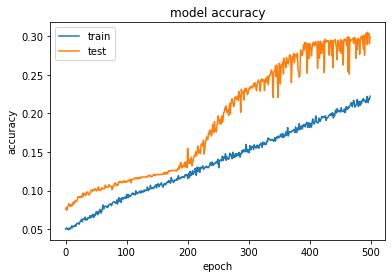

In [23]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

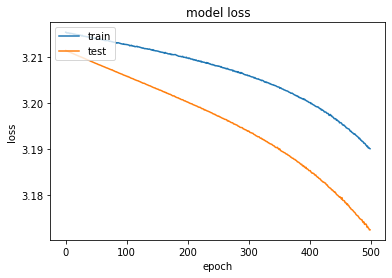

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Training the model again with smaller learning rate of 1e-6

In [16]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=1e-6, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [17]:
hist =train_model(epochs=100)

/tmp/ipykernel_172569/1599893955.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100
171/171 [==============================] - 25s 131ms/step - loss: 3.2193 - categorical_accuracy: 0.0353 - val_loss: 3.2170 - val_categorical_accuracy: 0.0513
Epoch 2/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2194 - categorical_accuracy: 0.0337 - val_loss: 3.2170 - val_categorical_accuracy: 0.0513
Epoch 3/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2194 - categorical_accuracy: 0.0340 - val_loss: 3.2174 - val_categorical_accuracy: 0.0425
Epoch 4/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2194 - categorical_accuracy: 0.0326 - val_loss: 3.2181 - val_categorical_accuracy: 0.0262
Epoch 5/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2193 - categorical_accuracy: 0.0340 - val_loss: 3.2184 - val_categorical_accuracy: 0.0128
Epoch 6/100
171/171 [==============================] - 21s 125ms/step - loss: 3.2193 - categorical_accuracy: 0.0359 - val_loss: 3.2186 - val_categoric

Epoch 49/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2192 - categorical_accuracy: 0.0322 - val_loss: 3.2183 - val_categorical_accuracy: 0.0134
Epoch 50/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2192 - categorical_accuracy: 0.0348 - val_loss: 3.2183 - val_categorical_accuracy: 0.0128
Epoch 51/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2193 - categorical_accuracy: 0.0320 - val_loss: 3.2183 - val_categorical_accuracy: 0.0128
Epoch 52/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2192 - categorical_accuracy: 0.0335 - val_loss: 3.2183 - val_categorical_accuracy: 0.0128
Epoch 53/100
171/171 [==============================] - 22s 127ms/step - loss: 3.2192 - categorical_accuracy: 0.0333 - val_loss: 3.2183 - val_categorical_accuracy: 0.0128
Epoch 54/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2192 - categorical_accuracy: 0.0318 - val_loss: 3.2183 - val_cat

Epoch 97/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2192 - categorical_accuracy: 0.0295 - val_loss: 3.2181 - val_categorical_accuracy: 0.0070
Epoch 98/100
171/171 [==============================] - 22s 125ms/step - loss: 3.2191 - categorical_accuracy: 0.0328 - val_loss: 3.2181 - val_categorical_accuracy: 0.0076
Epoch 99/100
171/171 [==============================] - 22s 128ms/step - loss: 3.2192 - categorical_accuracy: 0.0306 - val_loss: 3.2181 - val_categorical_accuracy: 0.0076
Epoch 100/100
171/171 [==============================] - 22s 126ms/step - loss: 3.2191 - categorical_accuracy: 0.0313 - val_loss: 3.2181 - val_categorical_accuracy: 0.0082


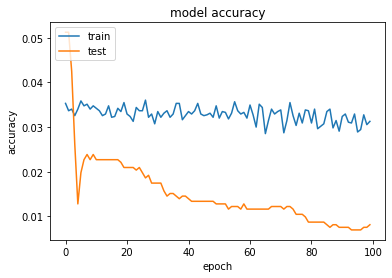

In [18]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

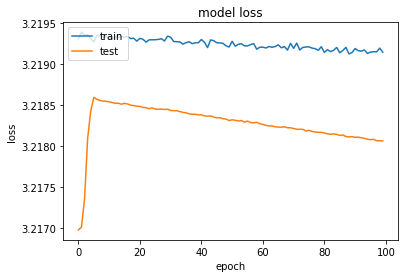

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# The best results were yield by using the learning rate as 1e-5. Continuing training with that hyper-parameter setting.

In [20]:
for layer in model.layers:
    layer.trainable = True

sgd = keras.optimizers.SGD(lr=1e-5, decay=1e-9, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy"])

In [21]:
hist =train_model(epochs=500)

/tmp/ipykernel_182981/1599893955.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/500
171/171 [==============================] - 25s 132ms/step - loss: 3.2191 - categorical_accuracy: 0.0366 - val_loss: 3.2193 - val_categorical_accuracy: 0.0291
Epoch 2/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2191 - categorical_accuracy: 0.0368 - val_loss: 3.2192 - val_categorical_accuracy: 0.0291
Epoch 3/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2191 - categorical_accuracy: 0.0366 - val_loss: 3.2190 - val_categorical_accuracy: 0.0291
Epoch 4/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2191 - categorical_accuracy: 0.0366 - val_loss: 3.2190 - val_categorical_accuracy: 0.0291
Epoch 5/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2190 - categorical_accuracy: 0.0366 - val_loss: 3.2191 - val_categorical_accuracy: 0.0291
Epoch 6/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2190 - categorical_accuracy: 0.0368 - val_loss: 3.2191 - val_categoric

Epoch 49/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2178 - categorical_accuracy: 0.0379 - val_loss: 3.2165 - val_categorical_accuracy: 0.0280
Epoch 50/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2178 - categorical_accuracy: 0.0366 - val_loss: 3.2164 - val_categorical_accuracy: 0.0332
Epoch 51/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2178 - categorical_accuracy: 0.0443 - val_loss: 3.2164 - val_categorical_accuracy: 0.0373
Epoch 52/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2177 - categorical_accuracy: 0.0437 - val_loss: 3.2163 - val_categorical_accuracy: 0.0454
Epoch 53/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2177 - categorical_accuracy: 0.0417 - val_loss: 3.2163 - val_categorical_accuracy: 0.0513
Epoch 54/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2177 - categorical_accuracy: 0.0452 - val_loss: 3.2162 - val_cat

Epoch 97/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2166 - categorical_accuracy: 0.0622 - val_loss: 3.2138 - val_categorical_accuracy: 0.0810
Epoch 98/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2165 - categorical_accuracy: 0.0664 - val_loss: 3.2138 - val_categorical_accuracy: 0.0810
Epoch 99/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2166 - categorical_accuracy: 0.0619 - val_loss: 3.2137 - val_categorical_accuracy: 0.0804
Epoch 100/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2165 - categorical_accuracy: 0.0657 - val_loss: 3.2136 - val_categorical_accuracy: 0.0821
Epoch 101/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2165 - categorical_accuracy: 0.0637 - val_loss: 3.2136 - val_categorical_accuracy: 0.0815
Epoch 102/500
171/171 [==============================] - 21s 125ms/step - loss: 3.2165 - categorical_accuracy: 0.0619 - val_loss: 3.2135 - val_

Epoch 145/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2154 - categorical_accuracy: 0.0653 - val_loss: 3.2112 - val_categorical_accuracy: 0.0763
Epoch 146/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2155 - categorical_accuracy: 0.0633 - val_loss: 3.2112 - val_categorical_accuracy: 0.0792
Epoch 147/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2154 - categorical_accuracy: 0.0622 - val_loss: 3.2111 - val_categorical_accuracy: 0.0786
Epoch 148/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2154 - categorical_accuracy: 0.0630 - val_loss: 3.2111 - val_categorical_accuracy: 0.0769
Epoch 149/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2153 - categorical_accuracy: 0.0650 - val_loss: 3.2110 - val_categorical_accuracy: 0.0792
Epoch 150/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2153 - categorical_accuracy: 0.0657 - val_loss: 3.2110 - v

171/171 [==============================] - 22s 129ms/step - loss: 3.2143 - categorical_accuracy: 0.0642 - val_loss: 3.2087 - val_categorical_accuracy: 0.0798
Epoch 193/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2142 - categorical_accuracy: 0.0608 - val_loss: 3.2086 - val_categorical_accuracy: 0.0798
Epoch 194/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2142 - categorical_accuracy: 0.0637 - val_loss: 3.2086 - val_categorical_accuracy: 0.0815
Epoch 195/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2141 - categorical_accuracy: 0.0631 - val_loss: 3.2086 - val_categorical_accuracy: 0.0810
Epoch 196/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2142 - categorical_accuracy: 0.0655 - val_loss: 3.2085 - val_categorical_accuracy: 0.0839
Epoch 197/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2141 - categorical_accuracy: 0.0635 - val_loss: 3.2084 - val_categorical

Epoch 240/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2131 - categorical_accuracy: 0.0668 - val_loss: 3.2062 - val_categorical_accuracy: 0.0944
Epoch 241/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2131 - categorical_accuracy: 0.0666 - val_loss: 3.2062 - val_categorical_accuracy: 0.0944
Epoch 242/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2130 - categorical_accuracy: 0.0690 - val_loss: 3.2061 - val_categorical_accuracy: 0.0938
Epoch 243/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2130 - categorical_accuracy: 0.0670 - val_loss: 3.2061 - val_categorical_accuracy: 0.0944
Epoch 244/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2129 - categorical_accuracy: 0.0703 - val_loss: 3.2060 - val_categorical_accuracy: 0.0944
Epoch 245/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2130 - categorical_accuracy: 0.0708 - val_loss: 3.2059 - v

171/171 [==============================] - 22s 128ms/step - loss: 3.2118 - categorical_accuracy: 0.0792 - val_loss: 3.2037 - val_categorical_accuracy: 0.1025
Epoch 288/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2118 - categorical_accuracy: 0.0767 - val_loss: 3.2037 - val_categorical_accuracy: 0.1002
Epoch 289/500
171/171 [==============================] - 23s 135ms/step - loss: 3.2117 - categorical_accuracy: 0.0807 - val_loss: 3.2035 - val_categorical_accuracy: 0.0996
Epoch 290/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2117 - categorical_accuracy: 0.0781 - val_loss: 3.2035 - val_categorical_accuracy: 0.0984
Epoch 291/500
171/171 [==============================] - 23s 133ms/step - loss: 3.2117 - categorical_accuracy: 0.0802 - val_loss: 3.2035 - val_categorical_accuracy: 0.1013
Epoch 292/500
171/171 [==============================] - 23s 131ms/step - loss: 3.2116 - categorical_accuracy: 0.0807 - val_loss: 3.2034 - val_categorical

Epoch 335/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2103 - categorical_accuracy: 0.0977 - val_loss: 3.2010 - val_categorical_accuracy: 0.1165
Epoch 336/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2102 - categorical_accuracy: 0.1016 - val_loss: 3.2009 - val_categorical_accuracy: 0.1112
Epoch 337/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2102 - categorical_accuracy: 0.0972 - val_loss: 3.2009 - val_categorical_accuracy: 0.1142
Epoch 338/500
171/171 [==============================] - 21s 124ms/step - loss: 3.2102 - categorical_accuracy: 0.0959 - val_loss: 3.2008 - val_categorical_accuracy: 0.1153
Epoch 339/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2102 - categorical_accuracy: 0.0981 - val_loss: 3.2007 - val_categorical_accuracy: 0.1142
Epoch 340/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2101 - categorical_accuracy: 0.0950 - val_loss: 3.2007 - v

171/171 [==============================] - 22s 128ms/step - loss: 3.2088 - categorical_accuracy: 0.1072 - val_loss: 3.1983 - val_categorical_accuracy: 0.1299
Epoch 383/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2087 - categorical_accuracy: 0.1131 - val_loss: 3.1983 - val_categorical_accuracy: 0.1281
Epoch 384/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2088 - categorical_accuracy: 0.1135 - val_loss: 3.1982 - val_categorical_accuracy: 0.1299
Epoch 385/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2088 - categorical_accuracy: 0.1078 - val_loss: 3.1983 - val_categorical_accuracy: 0.1293
Epoch 386/500
171/171 [==============================] - 22s 130ms/step - loss: 3.2087 - categorical_accuracy: 0.1120 - val_loss: 3.1981 - val_categorical_accuracy: 0.1316
Epoch 387/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2086 - categorical_accuracy: 0.1102 - val_loss: 3.1980 - val_categorical

Epoch 430/500
171/171 [==============================] - 23s 132ms/step - loss: 3.2070 - categorical_accuracy: 0.1237 - val_loss: 3.1953 - val_categorical_accuracy: 0.1590
Epoch 431/500
171/171 [==============================] - 23s 133ms/step - loss: 3.2070 - categorical_accuracy: 0.1303 - val_loss: 3.1953 - val_categorical_accuracy: 0.1584
Epoch 432/500
171/171 [==============================] - 22s 131ms/step - loss: 3.2069 - categorical_accuracy: 0.1281 - val_loss: 3.1952 - val_categorical_accuracy: 0.1607
Epoch 433/500
171/171 [==============================] - 22s 129ms/step - loss: 3.2069 - categorical_accuracy: 0.1268 - val_loss: 3.1952 - val_categorical_accuracy: 0.1613
Epoch 434/500
171/171 [==============================] - 23s 132ms/step - loss: 3.2069 - categorical_accuracy: 0.1250 - val_loss: 3.1951 - val_categorical_accuracy: 0.1607
Epoch 435/500
171/171 [==============================] - 23s 131ms/step - loss: 3.2068 - categorical_accuracy: 0.1254 - val_loss: 3.1950 - v

171/171 [==============================] - 22s 127ms/step - loss: 3.2050 - categorical_accuracy: 0.1398 - val_loss: 3.1922 - val_categorical_accuracy: 0.1765
Epoch 478/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2050 - categorical_accuracy: 0.1493 - val_loss: 3.1921 - val_categorical_accuracy: 0.1765
Epoch 479/500
171/171 [==============================] - 22s 128ms/step - loss: 3.2048 - categorical_accuracy: 0.1460 - val_loss: 3.1921 - val_categorical_accuracy: 0.1765
Epoch 480/500
171/171 [==============================] - 22s 127ms/step - loss: 3.2049 - categorical_accuracy: 0.1402 - val_loss: 3.1920 - val_categorical_accuracy: 0.1858
Epoch 481/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2049 - categorical_accuracy: 0.1460 - val_loss: 3.1919 - val_categorical_accuracy: 0.1800
Epoch 482/500
171/171 [==============================] - 22s 126ms/step - loss: 3.2047 - categorical_accuracy: 0.1499 - val_loss: 3.1919 - val_categorical

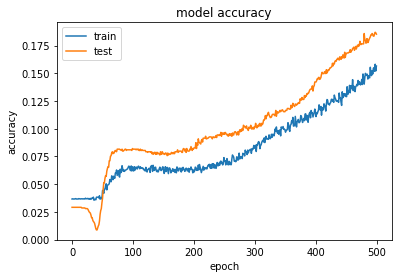

In [22]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

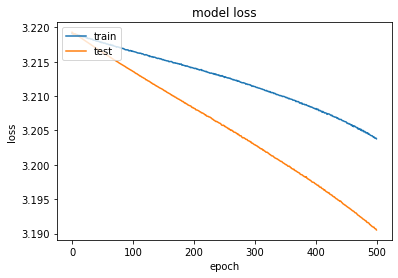

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
hist =train_model(epochs=1000)

/tmp/ipykernel_182981/1599893955.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.2038 - categorical_accuracy: 0.1526 - val_loss: 3.1904 - val_categorical_accuracy: 0.1893
Epoch 2/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.2037 - categorical_accuracy: 0.1572 - val_loss: 3.1904 - val_categorical_accuracy: 0.1846
Epoch 3/1000
171/171 [==============================] - 22s 125ms/step - loss: 3.2037 - categorical_accuracy: 0.1530 - val_loss: 3.1903 - val_categorical_accuracy: 0.1893
Epoch 4/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.2036 - categorical_accuracy: 0.1581 - val_loss: 3.1903 - val_categorical_accuracy: 0.1887
Epoch 5/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.2036 - categorical_accuracy: 0.1601 - val_loss: 3.1902 - val_categorical_accuracy: 0.1910
Epoch 6/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.2036 - categorical_accuracy: 0.1514 - val_loss: 3.1900 - val_cat

Epoch 49/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.2011 - categorical_accuracy: 0.1781 - val_loss: 3.1865 - val_categorical_accuracy: 0.2062
Epoch 50/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.2010 - categorical_accuracy: 0.1722 - val_loss: 3.1865 - val_categorical_accuracy: 0.2050
Epoch 51/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.2009 - categorical_accuracy: 0.1757 - val_loss: 3.1863 - val_categorical_accuracy: 0.2085
Epoch 52/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.2008 - categorical_accuracy: 0.1783 - val_loss: 3.1863 - val_categorical_accuracy: 0.2056
Epoch 53/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.2007 - categorical_accuracy: 0.1797 - val_loss: 3.1862 - val_categorical_accuracy: 0.2050
Epoch 54/1000
171/171 [==============================] - 22s 128ms/step - loss: 3.2007 - categorical_accuracy: 0.1762 - val_loss: 3.1861 - v

171/171 [==============================] - 21s 124ms/step - loss: 3.1975 - categorical_accuracy: 0.2035 - val_loss: 3.1822 - val_categorical_accuracy: 0.2213
Epoch 97/1000
171/171 [==============================] - 22s 130ms/step - loss: 3.1974 - categorical_accuracy: 0.2017 - val_loss: 3.1821 - val_categorical_accuracy: 0.2202
Epoch 98/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.1973 - categorical_accuracy: 0.1995 - val_loss: 3.1820 - val_categorical_accuracy: 0.2219
Epoch 99/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.1973 - categorical_accuracy: 0.2044 - val_loss: 3.1818 - val_categorical_accuracy: 0.2231
Epoch 100/1000
171/171 [==============================] - 22s 128ms/step - loss: 3.1973 - categorical_accuracy: 0.2048 - val_loss: 3.1815 - val_categorical_accuracy: 0.2254
Epoch 101/1000
171/171 [==============================] - 22s 130ms/step - loss: 3.1972 - categorical_accuracy: 0.2024 - val_loss: 3.1816 - val_categoric

171/171 [==============================] - 22s 128ms/step - loss: 3.1932 - categorical_accuracy: 0.2196 - val_loss: 3.1766 - val_categorical_accuracy: 0.2341
Epoch 144/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1931 - categorical_accuracy: 0.2220 - val_loss: 3.1764 - val_categorical_accuracy: 0.2353
Epoch 145/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1929 - categorical_accuracy: 0.2236 - val_loss: 3.1765 - val_categorical_accuracy: 0.2330
Epoch 146/1000
171/171 [==============================] - 22s 125ms/step - loss: 3.1929 - categorical_accuracy: 0.2227 - val_loss: 3.1762 - val_categorical_accuracy: 0.2353
Epoch 147/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1927 - categorical_accuracy: 0.2225 - val_loss: 3.1763 - val_categorical_accuracy: 0.2347
Epoch 148/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1926 - categorical_accuracy: 0.2216 - val_loss: 3.1759 - val_catego

171/171 [==============================] - 22s 126ms/step - loss: 3.1876 - categorical_accuracy: 0.2324 - val_loss: 3.1697 - val_categorical_accuracy: 0.2382
Epoch 191/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1875 - categorical_accuracy: 0.2293 - val_loss: 3.1698 - val_categorical_accuracy: 0.2335
Epoch 192/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1873 - categorical_accuracy: 0.2337 - val_loss: 3.1698 - val_categorical_accuracy: 0.2301
Epoch 193/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1870 - categorical_accuracy: 0.2306 - val_loss: 3.1693 - val_categorical_accuracy: 0.2347
Epoch 194/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1870 - categorical_accuracy: 0.2317 - val_loss: 3.1692 - val_categorical_accuracy: 0.2341
Epoch 195/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1866 - categorical_accuracy: 0.2379 - val_loss: 3.1693 - val_catego

171/171 [==============================] - 22s 128ms/step - loss: 3.1804 - categorical_accuracy: 0.2291 - val_loss: 3.1618 - val_categorical_accuracy: 0.2353
Epoch 238/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1800 - categorical_accuracy: 0.2427 - val_loss: 3.1617 - val_categorical_accuracy: 0.2289
Epoch 239/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1798 - categorical_accuracy: 0.2408 - val_loss: 3.1614 - val_categorical_accuracy: 0.2347
Epoch 240/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1797 - categorical_accuracy: 0.2350 - val_loss: 3.1614 - val_categorical_accuracy: 0.2324
Epoch 241/1000
171/171 [==============================] - 22s 131ms/step - loss: 3.1796 - categorical_accuracy: 0.2366 - val_loss: 3.1610 - val_categorical_accuracy: 0.2318
Epoch 242/1000
171/171 [==============================] - 22s 131ms/step - loss: 3.1793 - categorical_accuracy: 0.2408 - val_loss: 3.1609 - val_catego

171/171 [==============================] - 22s 131ms/step - loss: 3.1715 - categorical_accuracy: 0.2451 - val_loss: 3.1525 - val_categorical_accuracy: 0.2289
Epoch 285/1000
171/171 [==============================] - 22s 130ms/step - loss: 3.1712 - categorical_accuracy: 0.2432 - val_loss: 3.1521 - val_categorical_accuracy: 0.2236
Epoch 286/1000
171/171 [==============================] - 23s 131ms/step - loss: 3.1711 - categorical_accuracy: 0.2429 - val_loss: 3.1521 - val_categorical_accuracy: 0.2254
Epoch 287/1000
171/171 [==============================] - 22s 130ms/step - loss: 3.1707 - categorical_accuracy: 0.2418 - val_loss: 3.1515 - val_categorical_accuracy: 0.2306
Epoch 288/1000
171/171 [==============================] - 23s 132ms/step - loss: 3.1706 - categorical_accuracy: 0.2489 - val_loss: 3.1518 - val_categorical_accuracy: 0.2254
Epoch 289/1000
171/171 [==============================] - 22s 130ms/step - loss: 3.1703 - categorical_accuracy: 0.2451 - val_loss: 3.1512 - val_catego

171/171 [==============================] - 22s 127ms/step - loss: 3.1604 - categorical_accuracy: 0.2581 - val_loss: 3.1409 - val_categorical_accuracy: 0.2330
Epoch 332/1000
171/171 [==============================] - 22s 125ms/step - loss: 3.1602 - categorical_accuracy: 0.2601 - val_loss: 3.1406 - val_categorical_accuracy: 0.2341
Epoch 333/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1597 - categorical_accuracy: 0.2648 - val_loss: 3.1403 - val_categorical_accuracy: 0.2347
Epoch 334/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1596 - categorical_accuracy: 0.2560 - val_loss: 3.1407 - val_categorical_accuracy: 0.2330
Epoch 335/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1595 - categorical_accuracy: 0.2599 - val_loss: 3.1399 - val_categorical_accuracy: 0.2347
Epoch 336/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1588 - categorical_accuracy: 0.2619 - val_loss: 3.1398 - val_catego

171/171 [==============================] - 22s 126ms/step - loss: 3.1475 - categorical_accuracy: 0.2853 - val_loss: 3.1280 - val_categorical_accuracy: 0.2452
Epoch 379/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1471 - categorical_accuracy: 0.2829 - val_loss: 3.1275 - val_categorical_accuracy: 0.2586
Epoch 380/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1470 - categorical_accuracy: 0.2828 - val_loss: 3.1272 - val_categorical_accuracy: 0.2592
Epoch 381/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1464 - categorical_accuracy: 0.2831 - val_loss: 3.1274 - val_categorical_accuracy: 0.2598
Epoch 382/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1463 - categorical_accuracy: 0.2795 - val_loss: 3.1268 - val_categorical_accuracy: 0.2627
Epoch 383/1000
171/171 [==============================] - 22s 125ms/step - loss: 3.1458 - categorical_accuracy: 0.2868 - val_loss: 3.1283 - val_catego

171/171 [==============================] - 22s 125ms/step - loss: 3.1332 - categorical_accuracy: 0.3082 - val_loss: 3.1139 - val_categorical_accuracy: 0.2930
Epoch 426/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1326 - categorical_accuracy: 0.3113 - val_loss: 3.1138 - val_categorical_accuracy: 0.2947
Epoch 427/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1328 - categorical_accuracy: 0.3053 - val_loss: 3.1129 - val_categorical_accuracy: 0.2959
Epoch 428/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1323 - categorical_accuracy: 0.3029 - val_loss: 3.1128 - val_categorical_accuracy: 0.2819
Epoch 429/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1319 - categorical_accuracy: 0.3029 - val_loss: 3.1125 - val_categorical_accuracy: 0.2825
Epoch 430/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1316 - categorical_accuracy: 0.3060 - val_loss: 3.1125 - val_catego

171/171 [==============================] - 22s 126ms/step - loss: 3.1189 - categorical_accuracy: 0.3225 - val_loss: 3.0988 - val_categorical_accuracy: 0.3326
Epoch 473/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1185 - categorical_accuracy: 0.3300 - val_loss: 3.0981 - val_categorical_accuracy: 0.3395
Epoch 474/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1185 - categorical_accuracy: 0.3221 - val_loss: 3.0996 - val_categorical_accuracy: 0.3186
Epoch 475/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1181 - categorical_accuracy: 0.3236 - val_loss: 3.1100 - val_categorical_accuracy: 0.3069
Epoch 476/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1175 - categorical_accuracy: 0.3205 - val_loss: 3.0975 - val_categorical_accuracy: 0.3256
Epoch 477/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1167 - categorical_accuracy: 0.3276 - val_loss: 3.0971 - val_catego

171/171 [==============================] - 22s 126ms/step - loss: 3.1045 - categorical_accuracy: 0.3355 - val_loss: 3.0841 - val_categorical_accuracy: 0.3512
Epoch 520/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1037 - categorical_accuracy: 0.3450 - val_loss: 3.0933 - val_categorical_accuracy: 0.3139
Epoch 521/1000
171/171 [==============================] - 22s 125ms/step - loss: 3.1041 - categorical_accuracy: 0.3410 - val_loss: 3.0829 - val_categorical_accuracy: 0.3640
Epoch 522/1000
171/171 [==============================] - 22s 127ms/step - loss: 3.1034 - categorical_accuracy: 0.3421 - val_loss: 3.0854 - val_categorical_accuracy: 0.3425
Epoch 523/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1032 - categorical_accuracy: 0.3378 - val_loss: 3.0820 - val_categorical_accuracy: 0.3623
Epoch 524/1000
171/171 [==============================] - 22s 126ms/step - loss: 3.1028 - categorical_accuracy: 0.3395 - val_loss: 3.0873 - val_catego

171/171 [==============================] - 22s 128ms/step - loss: 3.0900 - categorical_accuracy: 0.3468 - val_loss: 3.0679 - val_categorical_accuracy: 0.3879
Epoch 567/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0895 - categorical_accuracy: 0.3514 - val_loss: 3.0676 - val_categorical_accuracy: 0.3821
Epoch 568/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0892 - categorical_accuracy: 0.3523 - val_loss: 3.0673 - val_categorical_accuracy: 0.3809
Epoch 569/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0888 - categorical_accuracy: 0.3540 - val_loss: 3.0686 - val_categorical_accuracy: 0.3751
Epoch 570/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0888 - categorical_accuracy: 0.3483 - val_loss: 3.0681 - val_categorical_accuracy: 0.3652
Epoch 571/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0885 - categorical_accuracy: 0.3552 - val_loss: 3.0704 - val_catego

171/171 [==============================] - 22s 128ms/step - loss: 3.0753 - categorical_accuracy: 0.3624 - val_loss: 3.0540 - val_categorical_accuracy: 0.3803
Epoch 614/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0756 - categorical_accuracy: 0.3607 - val_loss: 3.0519 - val_categorical_accuracy: 0.4182
Epoch 615/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0743 - categorical_accuracy: 0.3668 - val_loss: 3.0514 - val_categorical_accuracy: 0.4228
Epoch 616/1000
171/171 [==============================] - 22s 128ms/step - loss: 3.0744 - categorical_accuracy: 0.3604 - val_loss: 3.0529 - val_categorical_accuracy: 0.3914
Epoch 617/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0745 - categorical_accuracy: 0.3644 - val_loss: 3.0528 - val_categorical_accuracy: 0.3879
Epoch 618/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0740 - categorical_accuracy: 0.3648 - val_loss: 3.0516 - val_catego

171/171 [==============================] - 23s 134ms/step - loss: 3.0609 - categorical_accuracy: 0.3699 - val_loss: 3.0385 - val_categorical_accuracy: 0.4217
Epoch 661/1000
171/171 [==============================] - 21s 125ms/step - loss: 3.0605 - categorical_accuracy: 0.3734 - val_loss: 3.0422 - val_categorical_accuracy: 0.3937
Epoch 662/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0606 - categorical_accuracy: 0.3701 - val_loss: 3.0443 - val_categorical_accuracy: 0.3518
Epoch 663/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0604 - categorical_accuracy: 0.3766 - val_loss: 3.0488 - val_categorical_accuracy: 0.3442
Epoch 664/1000
171/171 [==============================] - 22s 128ms/step - loss: 3.0597 - categorical_accuracy: 0.3743 - val_loss: 3.0365 - val_categorical_accuracy: 0.4048
Epoch 665/1000
171/171 [==============================] - 22s 129ms/step - loss: 3.0595 - categorical_accuracy: 0.3757 - val_loss: 3.0390 - val_catego

171/171 [==============================] - 21s 123ms/step - loss: 3.0467 - categorical_accuracy: 0.3757 - val_loss: 3.0199 - val_categorical_accuracy: 0.4613
Epoch 708/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0466 - categorical_accuracy: 0.3774 - val_loss: 3.0210 - val_categorical_accuracy: 0.4613
Epoch 709/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0457 - categorical_accuracy: 0.3801 - val_loss: 3.0234 - val_categorical_accuracy: 0.3978
Epoch 710/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0457 - categorical_accuracy: 0.3739 - val_loss: 3.0230 - val_categorical_accuracy: 0.4118
Epoch 711/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0451 - categorical_accuracy: 0.3794 - val_loss: 3.0317 - val_categorical_accuracy: 0.3692
Epoch 712/1000
171/171 [==============================] - 21s 125ms/step - loss: 3.0446 - categorical_accuracy: 0.3827 - val_loss: 3.0275 - val_catego

171/171 [==============================] - 21s 123ms/step - loss: 3.0312 - categorical_accuracy: 0.3880 - val_loss: 3.0069 - val_categorical_accuracy: 0.4327
Epoch 755/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0306 - categorical_accuracy: 0.3911 - val_loss: 3.0051 - val_categorical_accuracy: 0.4770
Epoch 756/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0307 - categorical_accuracy: 0.3873 - val_loss: 3.0107 - val_categorical_accuracy: 0.4106
Epoch 757/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0303 - categorical_accuracy: 0.3898 - val_loss: 3.0042 - val_categorical_accuracy: 0.4729
Epoch 758/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0303 - categorical_accuracy: 0.3852 - val_loss: 3.0084 - val_categorical_accuracy: 0.4287
Epoch 759/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0298 - categorical_accuracy: 0.3856 - val_loss: 3.0096 - val_catego

171/171 [==============================] - 21s 124ms/step - loss: 3.0164 - categorical_accuracy: 0.3939 - val_loss: 2.9942 - val_categorical_accuracy: 0.4543
Epoch 802/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0167 - categorical_accuracy: 0.3955 - val_loss: 2.9946 - val_categorical_accuracy: 0.4718
Epoch 803/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0157 - categorical_accuracy: 0.3973 - val_loss: 2.9877 - val_categorical_accuracy: 0.4991
Epoch 804/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0158 - categorical_accuracy: 0.3917 - val_loss: 3.0551 - val_categorical_accuracy: 0.2429
Epoch 805/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0150 - categorical_accuracy: 0.3924 - val_loss: 2.9926 - val_categorical_accuracy: 0.4455
Epoch 806/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0145 - categorical_accuracy: 0.3909 - val_loss: 2.9898 - val_catego

171/171 [==============================] - 21s 123ms/step - loss: 3.0012 - categorical_accuracy: 0.3940 - val_loss: 2.9722 - val_categorical_accuracy: 0.5096
Epoch 849/1000
171/171 [==============================] - 21s 123ms/step - loss: 3.0013 - categorical_accuracy: 0.3984 - val_loss: 2.9767 - val_categorical_accuracy: 0.4543
Epoch 850/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0006 - categorical_accuracy: 0.4034 - val_loss: 2.9798 - val_categorical_accuracy: 0.4659
Epoch 851/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0005 - categorical_accuracy: 0.4026 - val_loss: 2.9733 - val_categorical_accuracy: 0.4980
Epoch 852/1000
171/171 [==============================] - 21s 124ms/step - loss: 3.0001 - categorical_accuracy: 0.3986 - val_loss: 2.9710 - val_categorical_accuracy: 0.4991
Epoch 853/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9999 - categorical_accuracy: 0.3979 - val_loss: 2.9745 - val_catego

171/171 [==============================] - 21s 124ms/step - loss: 2.9859 - categorical_accuracy: 0.4030 - val_loss: 2.9573 - val_categorical_accuracy: 0.5201
Epoch 896/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9866 - categorical_accuracy: 0.4039 - val_loss: 2.9549 - val_categorical_accuracy: 0.5073
Epoch 897/1000
171/171 [==============================] - 22s 125ms/step - loss: 2.9854 - categorical_accuracy: 0.4037 - val_loss: 2.9615 - val_categorical_accuracy: 0.4531
Epoch 898/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9845 - categorical_accuracy: 0.4012 - val_loss: 2.9544 - val_categorical_accuracy: 0.5038
Epoch 899/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9852 - categorical_accuracy: 0.4072 - val_loss: 2.9573 - val_categorical_accuracy: 0.5125
Epoch 900/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9850 - categorical_accuracy: 0.4025 - val_loss: 2.9542 - val_catego

171/171 [==============================] - 21s 124ms/step - loss: 2.9706 - categorical_accuracy: 0.4101 - val_loss: 2.9468 - val_categorical_accuracy: 0.4683
Epoch 943/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9709 - categorical_accuracy: 0.4142 - val_loss: 2.9657 - val_categorical_accuracy: 0.4019
Epoch 944/1000
171/171 [==============================] - 21s 123ms/step - loss: 2.9694 - categorical_accuracy: 0.4120 - val_loss: 2.9400 - val_categorical_accuracy: 0.5178
Epoch 945/1000
171/171 [==============================] - 21s 123ms/step - loss: 2.9700 - categorical_accuracy: 0.4068 - val_loss: 2.9533 - val_categorical_accuracy: 0.4351
Epoch 946/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9694 - categorical_accuracy: 0.4057 - val_loss: 2.9515 - val_categorical_accuracy: 0.4502
Epoch 947/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9688 - categorical_accuracy: 0.4092 - val_loss: 2.9387 - val_catego

171/171 [==============================] - 21s 123ms/step - loss: 2.9551 - categorical_accuracy: 0.4197 - val_loss: 2.9275 - val_categorical_accuracy: 0.4886
Epoch 990/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9552 - categorical_accuracy: 0.4131 - val_loss: 2.9591 - val_categorical_accuracy: 0.3850
Epoch 991/1000
171/171 [==============================] - 21s 125ms/step - loss: 2.9546 - categorical_accuracy: 0.4206 - val_loss: 2.9274 - val_categorical_accuracy: 0.5154
Epoch 992/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9543 - categorical_accuracy: 0.4211 - val_loss: 2.9216 - val_categorical_accuracy: 0.5294
Epoch 993/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9537 - categorical_accuracy: 0.4206 - val_loss: 2.9207 - val_categorical_accuracy: 0.5248
Epoch 994/1000
171/171 [==============================] - 21s 124ms/step - loss: 2.9533 - categorical_accuracy: 0.4211 - val_loss: 2.9210 - val_catego

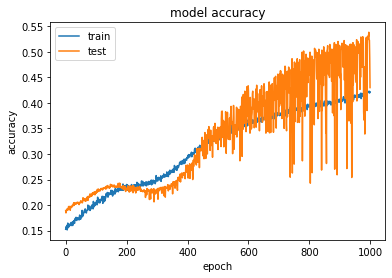

In [25]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

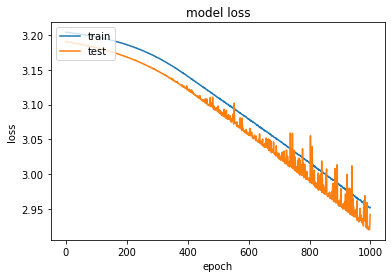

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model.load_weights('/home/orelit/Projects -Sathsara/Fine_grained_image_classification/doody_weights_3/weights.500-0.30.hdf5')

In [26]:
preds = model.predict_generator(test_generator, verbose=1)

/tmp/ipykernel_97520/119866773.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, verbose=1)


59/59 [==============================] - 1s 3ms/step


In [27]:
preds_cls_idx = preds.argmax(axis=-1)
preds_cls_idx

array([21, 21, 21, 21, 21, 21,  0,  0,  0, 21, 21, 21, 11,  0,  0,  0,  0,
        9, 11,  9,  9,  9,  9, 10, 21,  0, 10, 21, 21, 21, 21, 21, 21, 22,
       21, 21,  0,  0,  0,  0, 10, 22,  0,  0,  0,  0,  0, 10, 10, 10, 10,
        0, 21,  0,  0,  0,  0,  0, 22])

In [28]:
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
preds_cls

array(['7290115259209', '7290115259209', '7290115259209', '7290115259209',
       '7290115259209', '7290115259209', '0861432329', '0861432329',
       '0861432329', '7290115259209', '7290115259209', '7290115259209',
       '7290006492432', '0861432329', '0861432329', '0861432329',
       '0861432329', '7290004127329', '7290006492432', '7290004127329',
       '7290004127329', '7290004127329', '7290004127329', '7290004131074',
       '7290115259209', '0861432329', '7290004131074', '7290115259209',
       '7290115259209', '7290115259209', '7290115259209', '7290115259209',
       '7290115259209', '7290115259261', '7290115259209', '7290115259209',
       '0861432329', '0861432329', '0861432329', '0861432329',
       '7290004131074', '7290115259261', '0861432329', '0861432329',
       '0861432329', '0861432329', '0861432329', '7290004131074',
       '7290004131074', '7290004131074', '7290004131074', '0861432329',
       '7290115259209', '0861432329', '0861432329', '0861432329',
       '08614

In [29]:
true_lables = []
true_lables_upc_idx_map = {}
true_lables_img = {}
upc_list = os.listdir('/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_products_test/')
idx = 0
for upc in upc_list:
    img_folder = '/home/orelit/Projects -Sathsara/Fine_grained_image_classification/Doody_products_test/' + upc +'/'
    img_list = os.listdir(img_folder)
    for img in img_list:
        true_lables.append(upc)
        true_lables_upc_idx_map[idx] = upc
        true_lables_img[idx] = img
        idx += 1
len(true_lables)

60

In [30]:
true_lables

['7290004127077',
 '7290011923303',
 '7290115259261',
 '7290115259261',
 '7290004131074',
 '7290002824640',
 '7290004127329',
 '7290004127329',
 '7290004127329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '0861432329',
 '7290115259346',
 '7290115259346',
 '7290110324926',
 '7290000307237',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290115259193',
 '7290110328771',
 '7290110328771',
 '7290110328764',
 '7290110328764',
 '11111111',
 '11111111',
 '11111111',
 '7290115259179',
 '7290115259179',
 '7290115259179',
 '7290017217611',
 '7290004122195',
 '7290110328788',
 '7290110328788',
 '7290115259186',
 '7290115259186',
 '7290115259186',
 '7290115259186',
 '7290000168173',
 '7290000048185',
 

In [31]:
wrong_predicted = []
count = 0
for idx in range(0, len(preds_cls)):
    if preds_cls[idx] != true_lables[idx]:
        wrong_predicted.append(idx)
    else:
        count += 1
count

4

In [32]:
len(wrong_predicted)

55

In [38]:
accuracy = count/len(preds_cls)
accuracy

0.0

In [ ]:
wrong_pred_upc = set()
for label in wrong_predicted:
    wrong_pred_upc.add(true_lables_upc_idx_map[label])
len(wrong_pred_upc), len(wrong_predicted)

In [ ]:
images_pred_wrong = []
for label in wrong_predicted:
    images_pred_wrong.append(true_lables_img[label])
len(images_pred_wrong)


In [ ]:
d={}
for i in range(0 ,len(images_pred_wrong)):
    if preds_cls[i] not in d.keys():
        d[preds_cls[i]] = 1
    else:
        d[preds_cls[i]] += 1
d, len(d)

In [ ]:
for i in range(0 ,len(images_pred_wrong)):
    img ='/home/orelit/Projects -Sathsara/Planigo/data/Wine_test/' + true_lables_upc_idx_map[wrong_predicted[i]] + '/' + images_pred_wrong[i]
    print(img, preds_cls[i])